In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

In [2]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete191TVK/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete191TVK/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [3]:
def resize(input_image, input_mask):
    return tf.image.resize(input_image, (128, 128)), tf.image.resize(input_mask, (128, 128))

In [4]:
def augment(input_image, input_mask):
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)
    return input_image, input_mask

In [5]:
def normalize(input_image, input_mask):
    return tf.cast(input_image, tf.float32) / 255.0, input_mask - 1

In [6]:
def load_image_train(datapoint):
    input_image = datapoint["image"]
    input_mask = datapoint["segmentation_mask"]
    input_image, input_mask = resize(input_image, input_mask)
    input_image, input_mask = augment(input_image, input_mask)
    input_image, input_mask = normalize(input_image, input_mask)
    return input_image, input_mask
   
def load_image_test(datapoint):
    input_image = datapoint["image"]
    input_mask = datapoint["segmentation_mask"]
    input_image, input_mask = resize(input_image, input_mask)
    input_image, input_mask = normalize(input_image, input_mask)
    return input_image, input_mask

In [7]:
train_dataset = dataset["train"].map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = dataset["test"].map(load_image_test, num_parallel_calls=tf.data.AUTOTUNE)

In [8]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
train_batches = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_batches = train_batches.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_batches = test_dataset.take(3000).batch(BATCH_SIZE)
test_batches = test_dataset.skip(3000).take(669).batch(BATCH_SIZE)

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


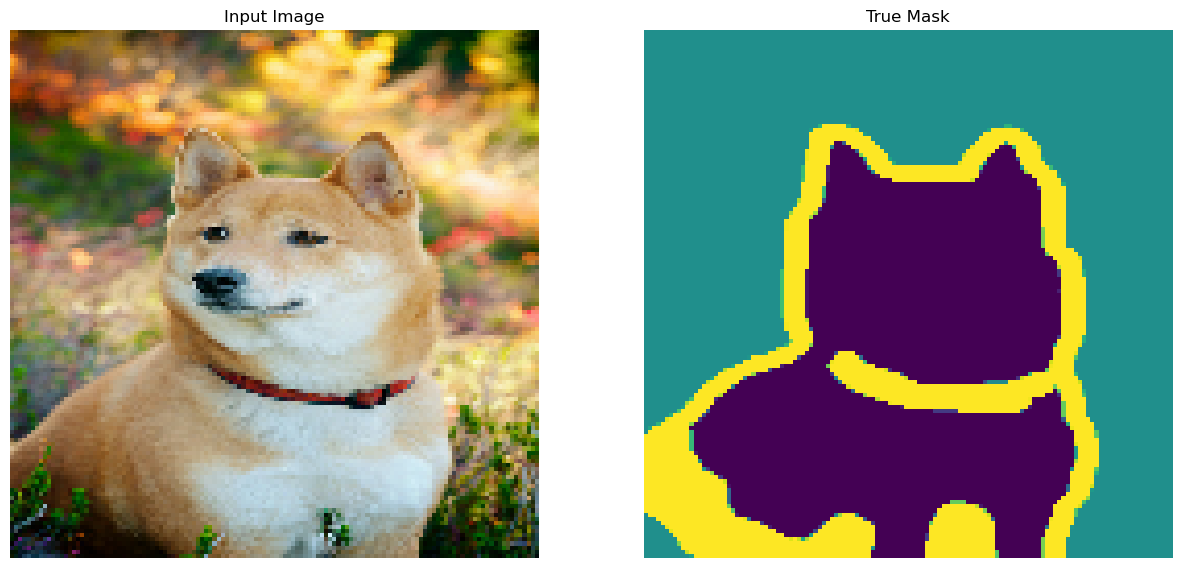

In [9]:
def display(display_list):
    plt.figure(figsize=(15, 15))
    title = ["Input Image", "True Mask", "Predicted Mask"]
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis("off")
    plt.show()
sample_batch = next(iter(train_batches))
random_index = np.random.choice(sample_batch[0].shape[0])
sample_image, sample_mask = sample_batch[0][random_index], sample_batch[1][random_index]
display([sample_image, sample_mask])

In [109]:
def double_conv_block(x, n_filters):
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    return x

def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = layers.MaxPool2D(2)(f)
    p = layers.Dropout(0.3)(p)
    return f, p

def upsample_block(x, conv_features, n_filters):
    x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
    x = layers.concatenate([x, conv_features])
    x = layers.Dropout(0.3)(x)
    x = double_conv_block(x, n_filters)
    return x

In [110]:
 def build_unet_model():
    inputs = layers.Input(shape=(128,128,3))
    f1, p1 = downsample_block(inputs, 64)
    f2, p2 = downsample_block(p1, 128)
    f3, p3 = downsample_block(p2, 256)
    f4, p4 = downsample_block(p3, 512)
    bottleneck = double_conv_block(p4, 1024)
    u6 = upsample_block(bottleneck, f4, 512)
    u7 = upsample_block(u6, f3, 256)
    u8 = upsample_block(u7, f2, 128)
    u9 = upsample_block(u8, f1, 64)
    outputs = layers.Conv2D(3, 1, padding="same", activation = "softmax")(u9)
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")
    return unet_model

In [14]:
unet_model = build_unet_model()
unet_model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss="sparse_categorical_crossentropy",
                  metrics="accuracy")
unet_model.summary()

In [16]:
NUM_EPOCHS = 5
TRAIN_LENGTH = info.splits["train"].num_examples
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
VAL_SUBSPLITS = 5
TEST_LENTH = info.splits["test"].num_examples
VALIDATION_STEPS = TEST_LENTH // BATCH_SIZE // VAL_SUBSPLITS
model_history = unet_model.fit(train_batches,
                              epochs=NUM_EPOCHS,
                              steps_per_epoch=STEPS_PER_EPOCH,
                              validation_steps=VALIDATION_STEPS,
                              validation_data=test_batches,callbacks=tf.keras.callbacks.EarlyStopping(patience=3,restore_best_weights=True))

Epoch 1/5


2024-10-10 14:38:09.509080: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inU-Net/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


57/57 [==============================] - 59s 653ms/step - loss: 0.9054 - accuracy: 0.5736 - val_loss: 0.7996 - val_accuracy: 0.6305
Epoch 2/5
57/57 [==============================] - 38s 584ms/step - loss: 0.7249 - accuracy: 0.6739 - val_loss: 0.6362 - val_accuracy: 0.7394
Epoch 3/5
57/57 [==============================] - 33s 579ms/step - loss: 0.6154 - accuracy: 0.7409 - val_loss: 0.5903 - val_accuracy: 0.7498
Epoch 4/5
57/57 [==============================] - 33s 578ms/step - loss: 0.5502 - accuracy: 0.7728 - val_loss: 0.5438 - val_accuracy: 0.7797
Epoch 5/5
57/57 [==============================] - 33s 577ms/step - loss: 0.5110 - accuracy: 0.7899 - val_loss: 0.4740 - val_accuracy: 0.8057


In [80]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = unet_model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
        else:
            display([sample_image, sample_mask,
                create_mask(unet_model.predict(sample_image[tf.newaxis, ...]))])
count = 0
for i in test_batches:
    count +=1
print("number of batches:", count)

number of batches: 11


2/2 [==============================] - 0s 69ms/step


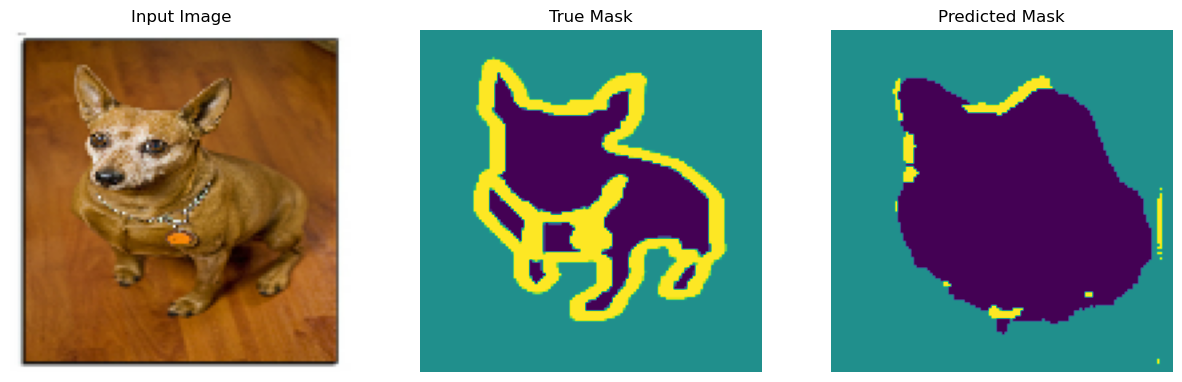

2/2 [==============================] - 0s 71ms/step


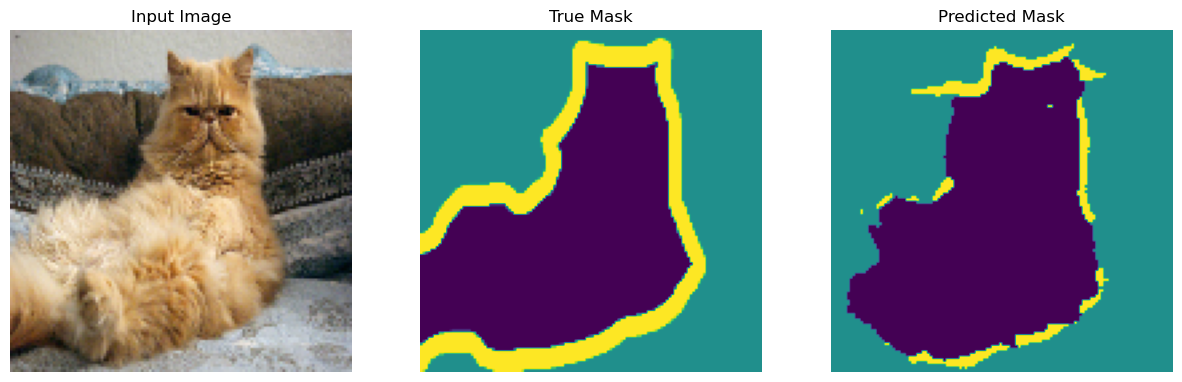

2/2 [==============================] - 0s 64ms/step


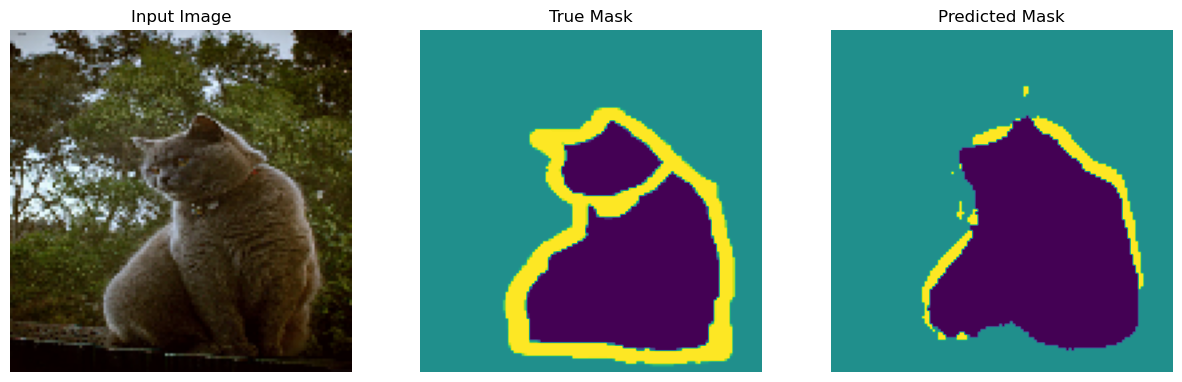

2/2 [==============================] - 0s 63ms/step


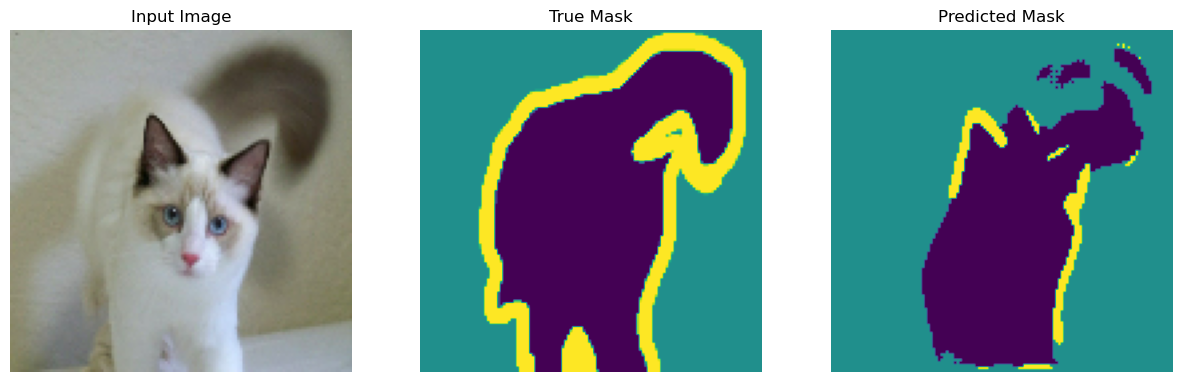

2/2 [==============================] - 0s 64ms/step


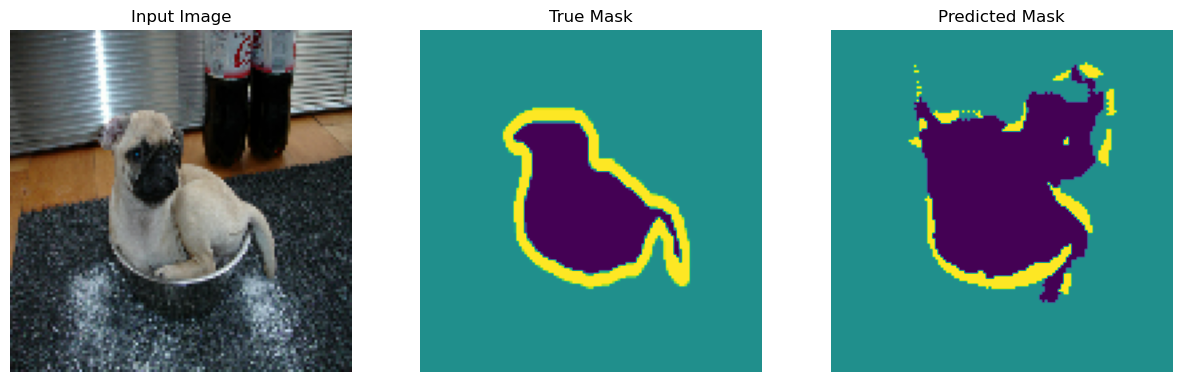

1/1 [==============================] - 0s 21ms/step


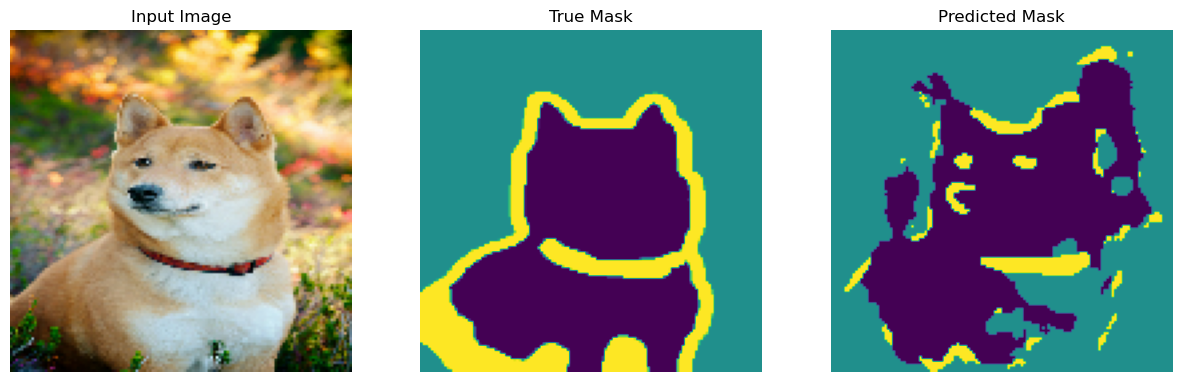

In [81]:
show_predictions(test_batches, num=5)  


In [82]:
unet_model.save('unet')

# FCNet

In [88]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate,Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [113]:
def fcn_model(input_shape=(128, 128, 3)):
    inputs = Input(shape=input_shape)
    # Encoder (Using VGG-like architecture)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    # Fully Convolutional Layers
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    # Upsampling to input size
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)
    # Output Layer
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(x)
    model = Model(inputs, outputs)
    return model

In [114]:
fcn = fcn_model()
fcn.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
fcn.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_25 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_158 (Conv2D)         (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d_51 (MaxPoolin  (None, 64, 64, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_159 (Conv2D)         (None, 64, 64, 128)       73856     
                                                                 
 max_pooling2d_52 (MaxPoolin  (None, 32, 32, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_160 (Conv2D)         (None, 32, 32, 256)       295

In [115]:
NUM_EPOCHS = 5
TRAIN_LENGTH = info.splits["train"].num_examples
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
VAL_SUBSPLITS = 5
TEST_LENTH = info.splits["test"].num_examples
VALIDATION_STEPS = TEST_LENTH // BATCH_SIZE // VAL_SUBSPLITS
model_history = fcn.fit(train_batches,
                              epochs=NUM_EPOCHS,
                              steps_per_epoch=STEPS_PER_EPOCH,
                              validation_steps=VALIDATION_STEPS,
                              validation_data=test_batches,callbacks=tf.keras.callbacks.EarlyStopping(patience=3,restore_best_weights=True))

Epoch 1/5
306/306 [==============================] - 34s 102ms/step - loss: -2358600192.0000 - accuracy: 0.5762 - val_loss: -16327578624.0000 - val_accuracy: 0.5509
Epoch 2/5
306/306 [==============================] - 26s 86ms/step - loss: -1831149508755456.0000 - accuracy: 0.5799
Epoch 3/5
306/306 [==============================] - 26s 86ms/step - loss: -3508272498762317824.0000 - accuracy: 0.5873
Epoch 4/5
306/306 [==============================] - 26s 85ms/step - loss: -927495919828467712.0000 - accuracy: 0.5490
Epoch 5/5
306/306 [==============================] - 26s 85ms/step - loss: 92067.5469 - accuracy: 0.5582


In [116]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = unet_model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
        else:
            display([sample_image, sample_mask,
                create_mask(fcn.predict(sample_image[tf.newaxis, ...]))])
count = 0
for i in test_batches:
    count +=1
print("number of batches:", count)

number of batches: 11


2/2 [==============================] - 0s 69ms/step


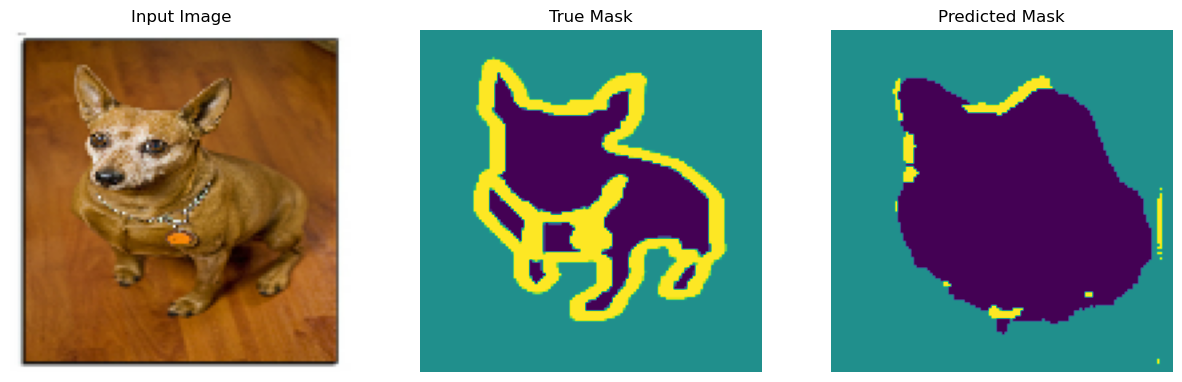

2/2 [==============================] - 0s 64ms/step


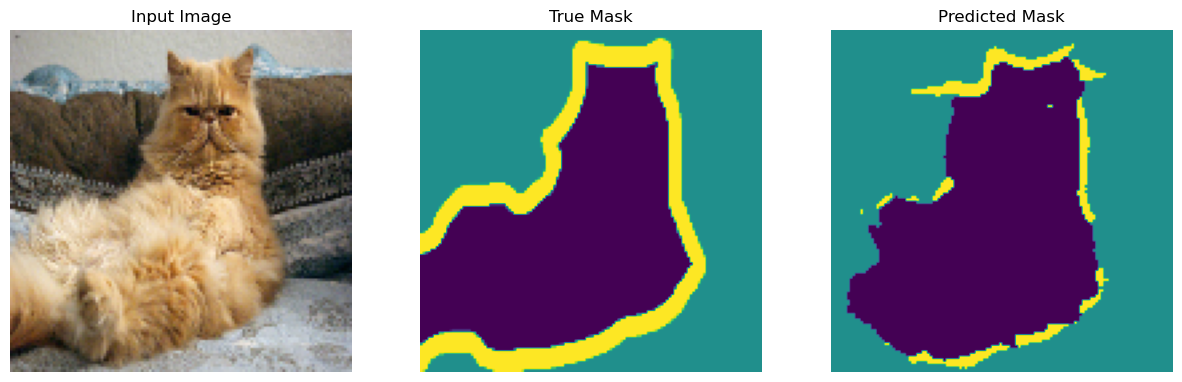

2/2 [==============================] - 0s 64ms/step


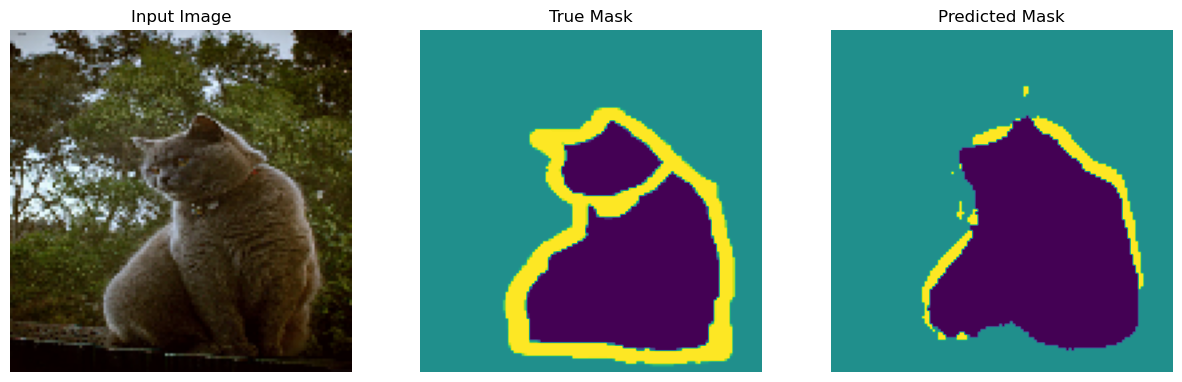

2/2 [==============================] - 0s 63ms/step


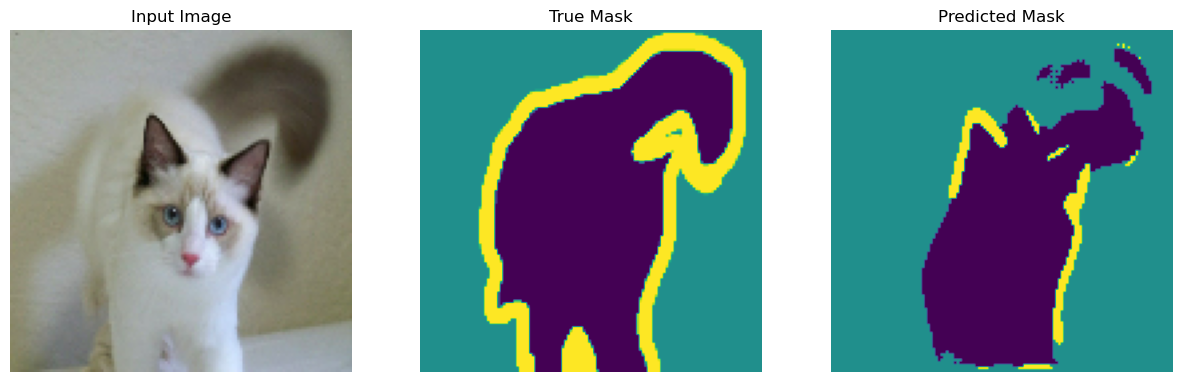

2/2 [==============================] - 0s 64ms/step


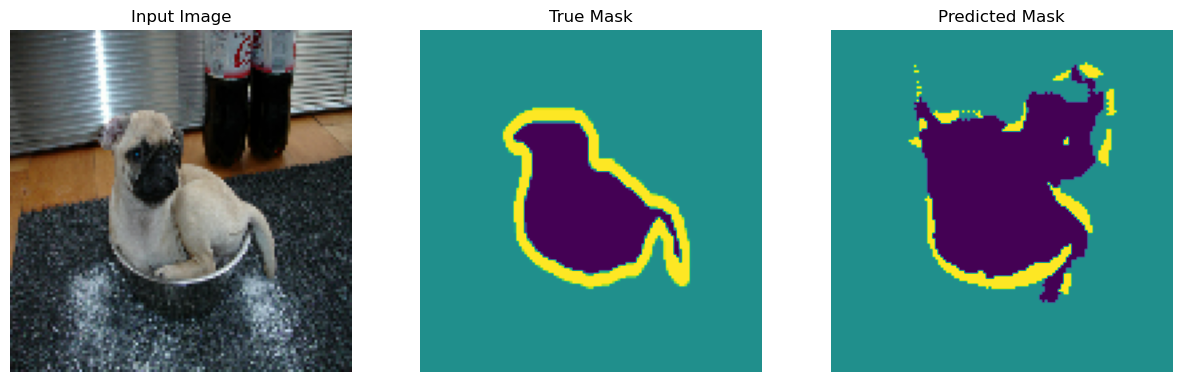

1/1 [==============================] - 0s 131ms/step


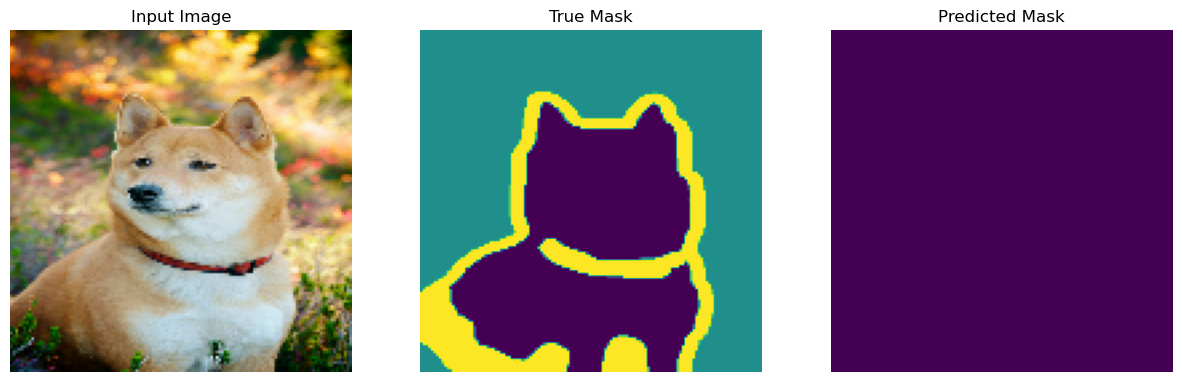

In [117]:
show_predictions(test_batches, num=5)  

# PSPNet

In [77]:
import tensorflow as tf
from tensorflow.keras import layers

def double_conv_block(x, n_filters):
    x = layers.Conv2D(n_filters, 3, padding="same", activation="relu", kernel_initializer="he_normal")(x)
    x = layers.Conv2D(n_filters, 3, padding="same", activation="relu", kernel_initializer="he_normal")(x)
    return x

def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = layers.MaxPool2D(2)(f)
    p = layers.Dropout(0.3)(p)
    return f, p

def pyramid_pooling_module(x):
    input_h, input_w = tf.keras.backend.int_shape(x)[1], tf.keras.backend.int_shape(x)[2]
    
    # Define pooling sizes
    pool_sizes = [(1, 1), (2, 2), (3, 3), (6, 6)]
    
    pooled_outputs = []
    for pool in pool_sizes:
        pooled = layers.AveragePooling2D(pool_size=pool, strides=pool, padding="same")(x)
        pooled = layers.Conv2D(512, (1, 1), padding="same", activation="relu")(pooled)
        upsampled = layers.UpSampling2D(size=pool)(pooled)
        
        # Crop or pad to match the original feature map size
        if upsampled.shape[1] != input_h or upsampled.shape[2] != input_w:
            upsampled = tf.image.resize(upsampled, (input_h, input_w))
        
        pooled_outputs.append(upsampled)
    
    # Concatenate the original input and the pyramid pooled outputs
    x = layers.concatenate([x] + pooled_outputs)
    
    return x

def upsample_block(x, conv_features, n_filters):
    x = layers.Conv2DTranspose(n_filters, 3, strides=2, padding="same")(x)
    x = layers.concatenate([x, conv_features])
    x = layers.Dropout(0.3)(x)
    x = double_conv_block(x, n_filters)
    return x

def build_pspnet_model():
    inputs = layers.Input(shape=(128, 128, 3))
    
    # Encoder: Downsampling blocks
    f1, p1 = downsample_block(inputs, 64)
    f2, p2 = downsample_block(p1, 128)
    f3, p3 = downsample_block(p2, 256)
    f4, p4 = downsample_block(p3, 512)
    
    # Bottleneck + Pyramid Pooling Module
    bottleneck = double_conv_block(p4, 1024)
    psp_features = pyramid_pooling_module(bottleneck)
    
    # Decoder: Upsampling blocks
    u6 = upsample_block(psp_features, f4, 512)
    u7 = upsample_block(u6, f3, 256)
    u8 = upsample_block(u7, f2, 128)
    u9 = upsample_block(u8, f1, 64)
    
    # Output layer
    outputs = layers.Conv2D(1, 1, padding="same", activation="softmax")(u9)
    
    # Model creation
    pspnet_model = tf.keras.Model(inputs, outputs, name="PSPNet")
    
    return pspnet_model


In [78]:

# Instantiate and compile the PSPNet model
pspnet_model = build_pspnet_model()
pspnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
pspnet_model.summary()


Model: "PSPNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_108 (Conv2D)            (None, 128, 128, 64  1792        ['input_15[0][0]']               
                                )                                                                 
                                                                                                  
 conv2d_109 (Conv2D)            (None, 128, 128, 64  36928       ['conv2d_108[0][0]']             
                                )                                                            

In [ ]:
NUM_EPOCHS = 5
TRAIN_LENGTH = info.splits["train"].num_examples
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
VAL_SUBSPLITS = 5
TEST_LENTH = info.splits["test"].num_examples
VALIDATION_STEPS = TEST_LENTH // BATCH_SIZE // VAL_SUBSPLITS
model_history = pspnet_model.fit(train_batches,
                              epochs=NUM_EPOCHS,
                              steps_per_epoch=STEPS_PER_EPOCH,
                              validation_steps=VALIDATION_STEPS,
                              validation_data=test_batches,callbacks=tf.keras.callbacks.EarlyStopping(patience=3,restore_best_weights=True))

In [66]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = unet_model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
        else:
            display([sample_image, sample_mask,
                create_mask(model.predict(sample_image[tf.newaxis, ...]))])
count = 0
for i in test_batches:
    count +=1
print("number of batches:", count)

number of batches: 11


2/2 [==============================] - 0s 69ms/step


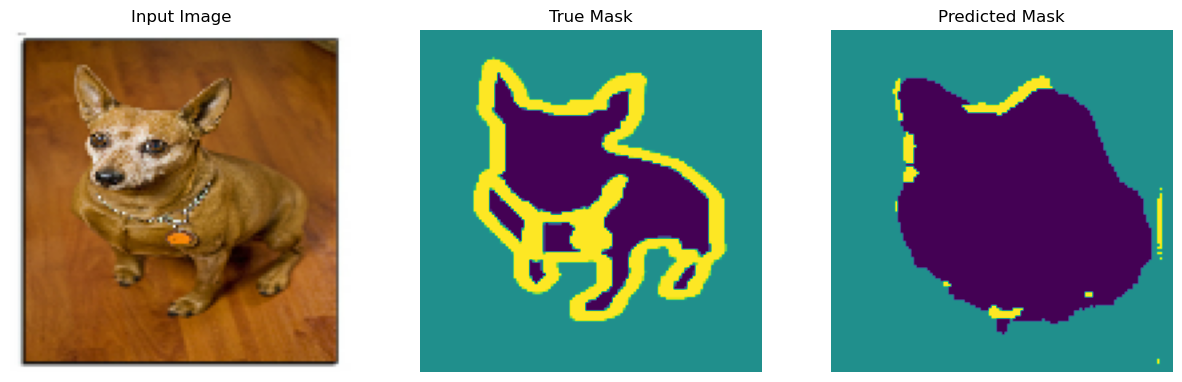

2/2 [==============================] - 0s 68ms/step


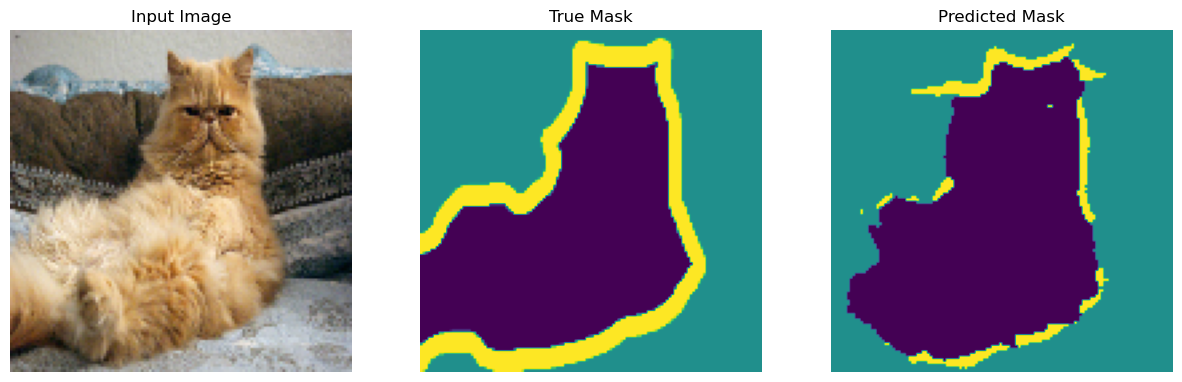

2/2 [==============================] - 0s 69ms/step


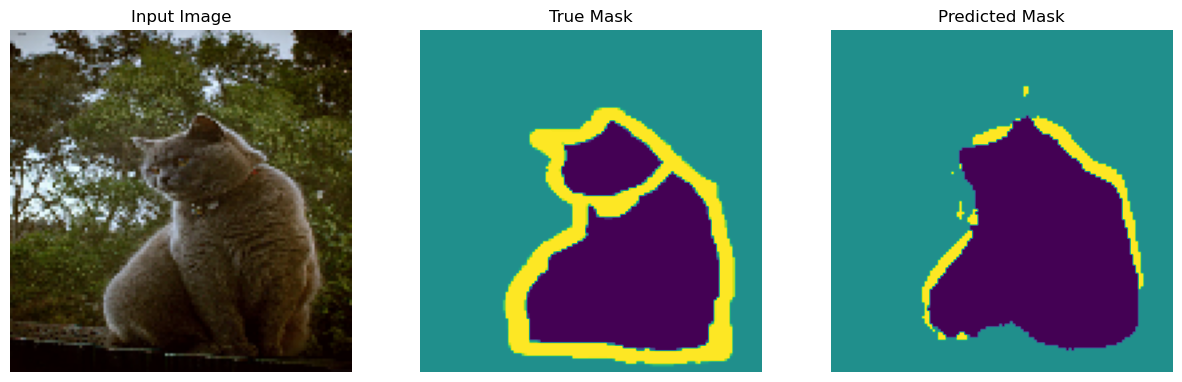

2/2 [==============================] - 0s 64ms/step


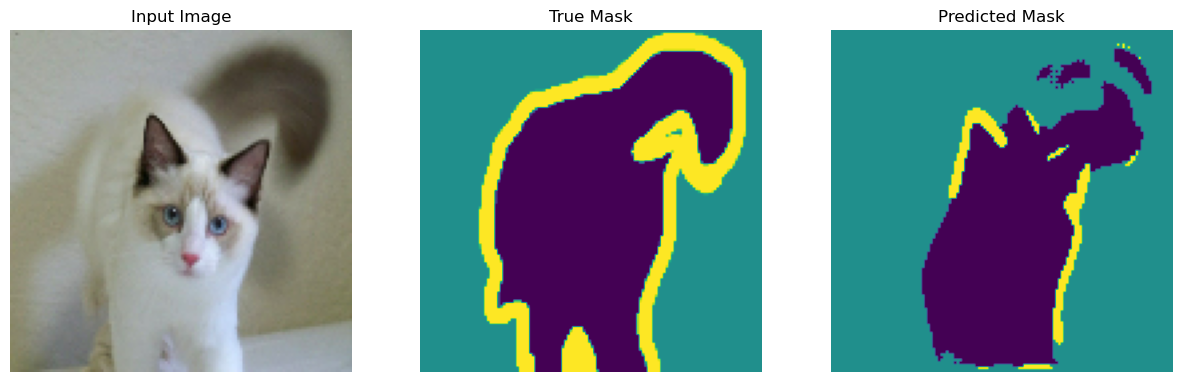

2/2 [==============================] - 0s 64ms/step


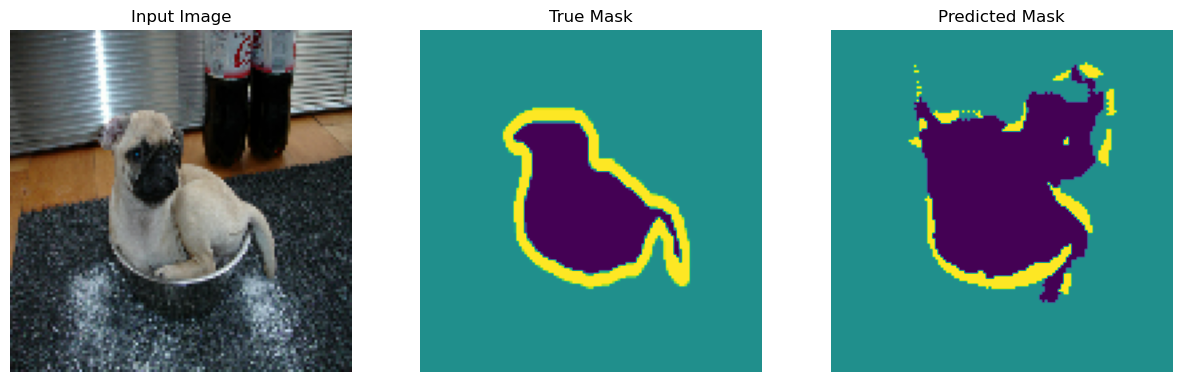

1/1 [==============================] - 0s 20ms/step


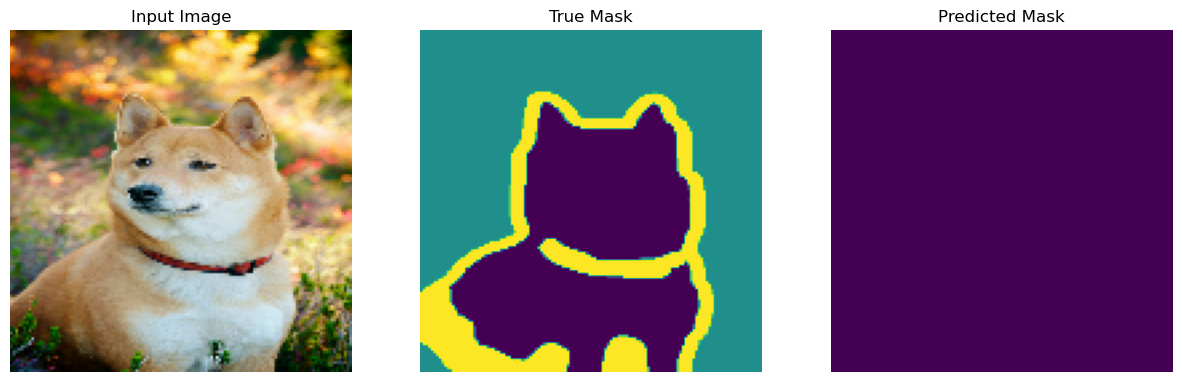

In [68]:
show_predictions(test_batches, num=5)  